# Exercise 3: Netflix Recommendation Algorithm

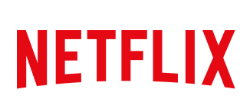

### Do not start the exercise until you fully understand the submission guidelines, which can be found herehttps://docs.google.com/document/d/1Qip08JKIppVX6dGX4hkrUCPgRmgkWYmQLEDZY_yZi90/edit?usp=sharing

#### For any material-related-questions, ask Ami.  For any organization-related-questions, ask the TA.

## Read the following instructions carefully:


1. Write your functions in this notebook only. **Do not create Python modules and import them**.
    1. Feel free to add code blocks if you need.
1. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will **not** be checked.
1. Kind reminder: the total of all exercises weight is 50% of the course's grade!

## This exercise summarizes the following subjects:
1. Netflix's personal recommendations algorithm:
    1. Content Filtering
    1. Collaborative Filtering
    1. Filling missing values in the Rating Matrix
    1. Matrix Factorization
    1. Data correlation finding approaches: SVD, PCA 
1. Applications of SVD and PCA:
    1. Face images compression and recognition using PCA
    1. Hand written digits recognition using SVD/PCA
    1. Correlations detection of mutations in the genom and different populations using SVD/PCA

# Part I: Netflix's Recommendations Algorithm

We demonstrated in class how to find similar movies (and recommend movies to a user, similar to a movie he likes), using **Ratings Matrix** where a list of users partially rated a list of movies. In class, we demonstarted 2 ways to handle the Rating Matrix using Excel sheets:

1. Calculate similarities (distances) between movies using the 1 to 5 rating values.
2. Turn the Rating Matrix into a **boolean** matrix where R(i,j)=TRUE if User i rated movie j above some threshold TH (1<=TH<=5).
Note that if TH=1 we get a rating matrix where **any** rating of a movie become TRUE in the boolean rating matrix. As mentioned in class, even such elementary representation is, supresingly, good data to work with.

In [214]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import os
import heapq

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Question 1 (20 points)

Write a code, based on the students' rating matrix (attatched to the homework assignment file: *our_course_ratings.csv*), to generate recommendations <ins>exactly</ins> as we demonstrated in class. That is, first translate the rating matrix to a boolean matrix using TH as a parameter in the code (use: TH=3 when you run the code. That is, ratings >= TH are marked TRUE, all other ratings, and non-ratings (zero values in the rating matrix) are FALSE. Make sure you allow to change TH to any new value from 1 to 5). Then, with the boolean rating matrix, your code will ask the user to enter a movie he liked, and present few movies that are most similar, and therefeore recommended for the user to watch.

Perform the task in the following sequence of operations.

#### 1.1 Read the Rating Matrix data (5 points)
Read the students' ratings matrix.

In [215]:
###########################################################################
#                            START OF YOUR CODE                           #
###########################################################################

# Fill the Rating matrix, M, with data from the CSV file.

data_location = os.getcwd()
filename = data_location+"\\our_course_ratings.csv"
debugMode = False
TH = 3

with open(filename, newline='') as file:
    result_list = list(csv.reader(file))

UserNames = result_list[0][2:]
MovieNames = []

M = []

for i in range(0,len(result_list)):
    if debugMode:
        print('Processing line i=',i)
    if i<3:
        if debugMode:
            print('Skip line',i,': ',result_list[i])
    else:
        current_line_values= []
        MovieNames.append(result_list[i][1])
        for j in range(2,len(result_list[i])):
            element = result_list[i][j]
            if element.isnumeric() and int(element) >= TH:
                current_line_values.append(True)
            else:
                current_line_values.append(False)

        if debugMode:
            print(current_line_values)
            
        M.append(current_line_values)


if debugMode:
    print(M)


print('\n\n',len(UserNames),' Users -\n',UserNames)
print('\n\n',len(MovieNames),' Movies -\n',MovieNames)

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################



 60  Users -
 ['Adi Z', 'Adir A', 'Amit E', 'Amit N', 'Amit Z', 'Artsi S', 'Asif A', 'Ami S', 'Barak A', 'Ben M', 'Yarden B', 'Daniella Z', 'Dean C', 'Dishi T', 'Dor S', 'Dov G', 'Erel B', 'Gal K', 'Gal M', 'Galia B', 'Goody B', 'Guy G', 'Guy K', 'Itay G', 'Itay J', 'Kai G', 'Koren O', 'Kylie K', 'Lihi S', 'Lior Levy', 'Lior Liv', 'Lior N', 'May N', 'Maya F', 'Monique R', 'Bar N', 'Niv M', 'Naama S', 'Omer M', 'Omri K', 'Ori L', 'Ori O', 'Roee M', 'Ron Z', 'Ronnie M', 'Snir Z', 'Stav Y', 'Tal A', 'Tal C', 'Tal Z', 'Tamir K', 'Tomer F', 'Yoav F', 'Yonatan L', 'Yuval D', 'Nir D', 'Nir K', 'ClassicUser', 'Anim-child', 'Action-Fict']


 334  Movies -
 ['Avatar (2009)', 'Avengers: Endgame (2019)', 'Titanic (1997)', 'Star Wars: Episode VII - The Force Awakens (2015)', 'Avengers: Infinity War (2018)', 'Spider-Man: No Way Home (2021)', 'Jurassic World (2015)', 'The Lion King (2019)', "Marvel's The Avengers (2012)", 'Furious 7 (2015)', 'Top Gun: Maverick (2022)', 'Frozen II (2019)', 'Avengers

#### 1.2 Recommendation algorithm implementation (15 points)
Implement the recommendation algorithm as we have seen in class. You can look at the excel and the calculations we did in it to create a "python version" of the algorithm.

Implement **GetUserFavoriteMovie()** :
1. Ask the user to enter a valid movieID.
1. Check it is valid (<u>do not</u> let the code crash or error if a value too high or too low or not an integer is entered by the user).
1. If it is valid user_movieID, print the user_movie_name (The complete string, as written in the excel sheet "Movie list").
1. Validate with the user this **is** the movie they liked.
1. If user changed his mind, allow him to enter **new** user_movieID and validate again in a loop until user confirms the user_movieID chosen.
1. Return the final user_movieID.

In [216]:
def GetUserFavoriteMovie() -> int:
    user_movie_name = None
    user_movieID = input("Enter a movie ID: ")
    ###########################################################################
    #                            START OF YOUR CODE                           #
    ###########################################################################
    if (user_movieID.isnumeric() == False or int(user_movieID) < 1 or int(user_movieID) > len(MovieNames)):
        print('Movie ID should be an integer between 1 and ',len(MovieNames))
        GetUserFavoriteMovie()
    else:
        user_movieID = int(user_movieID)
        user_movie_name = MovieNames[user_movieID - 1]
    
    print('You chose the movie ', user_movieID, ': ', user_movie_name)
    user_confirmation = input('To confirm enter y. To choose a different movie enter n.')
    
    while (not user_confirmation == 'y' and not user_confirmation == 'n'):
        user_confirmation = input('To confirm enter y. To choose a different movie enter n.')
    
    if (user_confirmation == 'n'):
        GetUserFavoriteMovie()
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    print(f'The user said he likes movie #"{user_movieID}": "{user_movie_name}"')
    return user_movieID

Implement **recommendation_alg()** :
1. Receive the Rating Matrix & user_movieID
1. Return $k$ other movies (not the movie they liked) recomended for him to watch. Recomended movies will be given by full name, not movie id.

In [217]:
def recommendation_alg(M, movie_id: int, k: int = 3) -> list[str]:
    '''
    Receives a movie the user likes and returns k other movies he might like.
    :param M: a ratings matrix
    :param movie_id: the id of the movie the user likes.
    :print the name of the movie id based on the movies list (it is in the same excel document the ratings are)
    :return: 3 other movies he might like, by names, not ids
    '''
    recommendations = []
    ###########################################################################
    #                            START OF YOUR CODE                           #
    ###########################################################################
    movie_score_dict = {}
    chosen_movie_name = MovieNames[movie_id - 1]
    chosen_movie_likes_count = M[movie_id - 1].count(True)
    
    for i in range (0, len(MovieNames)):
        if (not i == (movie_id - 1)):
            common_likes_count = 0
            current_movie_likes_count = M[i].count(True)
            current_movie_name = MovieNames[i]
            for j in range (0, len(UserNames)):
                if (M[i][j] == M[movie_id - 1][j] == True):
                    common_likes_count += 1
            if (min(chosen_movie_likes_count, current_movie_likes_count) == 0):
                movie_score_dict[current_movie_name] = 0
            else:
                movie_score_dict[current_movie_name] = common_likes_count / min(chosen_movie_likes_count, current_movie_likes_count)
    
    recommendations = heapq.nlargest(k, movie_score_dict, key=lambda x: movie_score_dict[x])
                          
                
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    assert type(recommendations) is list
    assert type(recommendations[0]) is str
    return recommendations

Implement **recommend()**:

1. Use the two earlier function you have implemented.

**Make sure first match has higher similarity score than the second one.** If it does not, <u>do not</u> submit the work, it is not working ok.

Finally, use <i>GetUserFavoriteMovie()</i> to get any movie the user likes and return k=3 other movies as a recommendation.

In [218]:
def recommend(M, k: int = 3):
    '''
    Ask a user input which is a movie the user likes and prints k other movies he might like.
    Validates user input.
    :param M: a ratings matrix
    '''
    user_movieID = -1
    user_movie = ''
    recommendations = []
    ###########################################################################
    #                            START OF YOUR CODE                           #
    ###########################################################################
    user_movieID = GetUserFavoriteMovie()
    recommendations = recommendation_alg(M, user_movieID, k)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    print(f'We recommend to watch: {recommendations}')

test the results using the following movieIDs (we will run it as well):

1. MovieID=15 (Harry Potter and the Deathly Hallows, Part 2).

1. MovieID=34 (Joker).

In [219]:
###########################################################################
#                            START OF YOUR CODE                           #
###########################################################################
recommend(M, 3)
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

Enter a movie ID: 34
You chose the movie  34 :  Joker (2019)
To confirm enter y. To choose a different movie enter n.y
The user said he likes movie #"34": "Joker (2019)"
We recommend to watch: ['The Fate of the Furious (2017)', 'Jurassic Park (1993)', 'Spectre (2015)']


## Question 2 (40 points)

Write a code that, using **SVD** analysis of the rating matrix, does the following 3 tasks (exactly as explained in class):
1. Show X=3 movies most similar to a certain movie
1. Shows X=3 users most similar to a certain user (choose yourself as the user and compare to the rest of the class to you).
1. Recommend X=3 movies to a user based on the vector representing the user preferences in martix $V^T$ and the movies data in matrix $U$.


You can look at the following implementations of SVD analysis to make sure your write the SVD analysis right. Note that the code in these links do **not** do exactly what you are asked to do here. You need to write your own code.

1. https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/

1. https://www.section.io/engineering-education/singular-value-decomposition-in-python/

### 2.1 Using SVD to calculate values in the original rating matrix M (5 points)
1. Make sure you use $M$ correctly. $M$ should have **users** as its **colomns** and **movies** as its **raws**.
1. Perform SVD on the ratings matrix, $M$. Remember: $U, S, V = np.linalg.svd(M)$ is a built-in function in python.
1. Calculate and print column i=1 of $M, M[i]$ using $U, S, V$. 
1. Calculate and print row j=15 of $M$ using $U, S, V$.

If your prints are **not** _excactly_ the same as the original rating matrix column and row, do **not** proceed. Check your code and fix it.

In [183]:
# Calculated the SVD decomposition of the original rating matrix M.
# Make sure the matrix M you work with has for columns the ratings of the users,
# i.e. column i has all the ratings of a specific user i for the movies he rated.
M = np.array(M)
U, S, V = np.linalg.svd(M)

def calculateSpecificRating(U, S, V, row: int, column: int):

    ###########################################################################
    #                            START OF YOUR CODE                           #
    ###########################################################################
    
    Sigma = np.zeros((M.shape[0], M.shape[1]))
    Sigma[:M.shape[1], :M.shape[1]] = np.diag(S)
    Reconstructed_M = U.dot(Sigma.dot(V))
    
    r = M[row][column]

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return(r)   # Returns the rating of user at M 'column' to movie at M 'row'
                # this MUST be exactly the value of M(row, column) but *without* having M for the calculation

In [184]:
column1 = []
for row in range(len(M)):
    column1.append(calculateSpecificRating(U, S, V, row, 1))
print(column1)

row15 = []
for column in range(len(M[0])):
    row15.append(calculateSpecificRating(U, S, V, 15, column))
print(row15)

[True, False, False, False, False, True, False, True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, False, True, True, False, False, False, True, True, False, False, True, True, True, False, False, False, False, False, True, False, False, True, False, True, False, True, False, False, False, False, False, False, True, False, True, False, False, False, False, False, True, False, False, False, False, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, 

### 2.2 Implementing recommendation algorithm using k-elements of SVD analysis of the rating matrix (30 points)
Use **cutSVD()** on the matrices $U, S, V$ to keep only the 1st k-columns of $U$, first k-scalars of $S$ and 1st k-rows of $V$. The size of the cut matrices is explained in detail in the class presentation. Use $k=10$ when you run the code. Remember to keep k a parameter in the code that is assinged a value. Do **not** use a number directly in the code. 

Use the cut matrices U_cut, S_cut, V_cut to do the follwing:
1. Show X=3 movies most similar to a certain movie. If the results are not as in question #1, try to change the value of $k$ and see how if effects the results. Discuss shortly the results.
1. Shows X=3 users most similar to a certain user (choose yourself as the user and compare to the rest of the class to you). If the results are not as in question #1, try to change the value of $k$ and see how if effects the results. Discuss shortly the results.
1. Recommend X=3 movies to a user based on the vector representing the user preferences in martix $V^T$ and the movies data in matrix $U$.

**Note**: To decide how similar 2 vectors 1 by k are to each other, choose one of the metrics we saw in class:
$$MSE(x,y) = SQRT( (x_1-y_1)^2 + (x_2-y_2)^2 + … + (x_k-y_k)^2)$$
$$or$$
$$L_1(x,y) = |x_1-y_1| + |x_2-y_2| + … + |x_k-y_k|$$

In [233]:
def cutSVD(U, S, V, k):
    '''
    Receives U, S, V and k and return the cut matrices U_cut, S_cut, V_cut.
    :param U: U part of SVD
    :param S: S part of SVD
    :param V: V part of SVD
    :param k: how many parameters from the original matrices to keep
    :return: U, S, V that are cut to the desired size
    '''
    ###########################################################################
    #                            START OF YOUR CODE                           #
    ###########################################################################
    U_cut = U[:, :k]
    S_cut = S[:k]
    V_cut = V[:k, :]
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return U_cut, S_cut, V_cut

U_cut, S_cut, V_cut = cutSVD(U, S, V, k=10)


In [234]:
def dist(x, y) -> float:
    '''
    Calculate the similarity of 2 movies/users.
    :param x: movies/users
    :param y: movies/users
    :return: distance / similarity score
    '''
    d = 0
    ###########################################################################
    #                            START OF YOUR CODE                           #
    ###########################################################################
    d = float(np.sqrt(np.sum((x - y) ** 2)))
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    assert type(d) is float
    return d

In [235]:
def similarMovies(U_cut, S_cut, V_cut, movie_id: int, x: int = 3) -> list[str]:
    '''
    Receives a movie the user likes and returns x movies he might also like.
    :param U_cut, S_cut, V_cut: the SVD presentation of the ratings matrix M,
    : after is was cut using cutSVD(U, S, V, k)
    :param movie_id: the id of the movie the user likes
    :param x: number of best results to return
    :return: X other movies he might like, by names, not ids
    '''
    recommendations = []
    ###########################################################################
    #                            START OF YOUR CODE                           #
    ###########################################################################
    movie_score_dict = {}
    chosen_movie = U_cut[movie_id - 1, :]
    
    for i in range(U_cut.shape[0]):
        if (not i == (movie_id - 1)):
            current_movie = U_cut[i, :]
            current_movie_name = MovieNames[i]
            distance = dist(chosen_movie, current_movie)
            movie_score_dict[current_movie_name] = distance
    
    recommendations = heapq.nsmallest(x, movie_score_dict, key=lambda x: movie_score_dict[x])
    

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    assert type(recommendations) is list
    assert type(recommendations[0]) is str
    return recommendations

similarMovies(U_cut, S_cut, V_cut, 15)

["Harry Potter and the Sorcerer's Stone (2001)",
 'Harry Potter and the Deathly Hallows, Part 1 (2010)',
 'Harry Potter and the Half-Blood Prince (2009)']

In [228]:
def similarUsers(U_cut, S_cut, V_cut, user_id: int, x: int = 3) -> list[str]:
    '''
    Receives a user_id the user likes and returns x other users most similar to this user.
    :param U_cut, S_cut, V_cut: the SVD presentation of the ratings matrix M,
    : after is was cut using cutSVD(U, S, V, k)
    :param user_id: the id of the user analysed
    :param x: number of best results to return
    :return: X other users most similar to the user, by names, not ids
    '''
    recommendations = []
    ###########################################################################
    #                            START OF YOUR CODE                           #
    ###########################################################################
    user_score_dict = {}
    chosen_user = V_cut[:, user_id - 1]
    
    for i in range(V_cut.shape[1]):
        if (not i == (user_id - 1)):
            current_user = V_cut[:, i]
            current_user_name = UserNames[i]
            distance = dist(chosen_user, current_user)
            user_score_dict[current_user_name] = distance
    
    recommendations = heapq.nsmallest(x, user_score_dict, key=lambda x: user_score_dict[x])
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    assert type(recommendations) is list
    assert type(recommendations[0]) is str
    return recommendations

similarUsers(U_cut, S_cut, V_cut, 14)

['Itay G', 'Gal M', 'Itay J']

In [229]:
def SVDFullRecomendationAlgo(U_cut, S_cut, V_cut, user_id: int, x: int = 3) -> list[str]:
    '''
    Receives a user_id and returns x movies most recommended to this user
    Based on ALL the users preferences as represented in the cut-U-S-V matrices.
    :param U_cut, S_cut, V_cut: the SVD presentation of the ratings matrix M,
    : after is was cut using cutSVD(U, S, V, k)
    :param user_id: the id of the user analysed
    :param x: number of best results to return
    :return: X most recommended movies he might like, by names, not ids
    '''
    recommendations = []
    ###########################################################################
    #                            START OF YOUR CODE                           #
    ###########################################################################
    movie_score_dict = {}
    chosen_user = V_cut[:, user_id - 1]
    
    for i in range(U_cut.shape[0]):
        current_movie = U_cut[i, :]
        current_movie_name = MovieNames[i]
        user_rating = np.dot(current_movie, chosen_user)
        movie_score_dict[current_movie_name] = user_rating
    
    recommendations = heapq.nsmallest(x, movie_score_dict, key=lambda x: movie_score_dict[x])
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    assert type(recommendations) is list
    assert type(recommendations[0]) is str
    return recommendations

SVDFullRecomendationAlgo(U_cut, S_cut, V_cut, 29)

['Coco (2017)',
 'The Sixth Sense (1999)',
 'Harry Potter and the Deathly Hallows: Part 2 (2011)']

### 2.3 Comparisings and discussion (5 points)
Submit the same ids as in 1.2 and show the results with the k-cut SVD method. Discuss the difference bewtween the outputs here and from question 1. How many values from the SVD decomposition (ie: what minimum k) gives answers as good as, or better, than the results using the code from question 1?

In [224]:
###########################################################################
#                            START OF YOUR CODE                           #
###########################################################################
def find_best_k(original_15_set, original_34_set, U, S, V):
    max_sum = -1
    max_k = -1
    for k in range(1, 60):
        U_cut, S_cut, V_cut = cutSVD(U, S, V ,k)
        movie_15_set = set(similarMovies(U_cut, S_cut, V_cut, 15))
        movie_34_set = set(similarMovies(U_cut, S_cut, V_cut, 34))
        sum = len(movie_15_set.intersection(original_15_set)) + len(movie_34_set.intersection(original_34_set))
        if sum > max_sum:
            max_sum = sum
            max_k = k

    return max_sum, max_k

original_15_set = {'Jurassic Park (1993)', 'Harry Potter and the Deathly Hallows, Part 1 (2010)', 'Harry Potter and the Order of the Phoenix (2007)'}
original_34_set = {'The Fate of the Furious (2017)', 'Jurassic Park (1993)', 'Spectre (2015)'}

find_best_k(original_15_set, original_34_set, U, S, V)
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

(2, 6)

#### Notice that the best k is 6 but the SVD decomposition may give even better results than the recommendation function in 1.2 because it recommends mostly 'Harry Potter' movies to input 15 as apposed to the recommendation function in 1.2 that gave returned 'Jurassic Park' as well.

# Part II: Decomposing and assembling facial images using the PCA 

In the code file from class we demonstrated some things that can be done with the decomposition of a data structure of different faces using the PCA method. Specifically, we saw how to:
1. Create a face image using eigenvectors of face images (Eigenfaces) multiplies by Weights.
1. Find faces most similar to a given face image using weights comparison.
1. Morph two images by gradual shift of the weights used to construct a face image from one image's weights to the other image's weights.
1. Calculate the error of an image constucted from eigenvectors and see how it decreases (very quickly) as we add more eigenvectors.

## Question 3: Subject (40 Points)

In this question we will use the code we saw in class and add some new capabilities.

### 3.1 add a face image of yourself to the database
Add a photos of each partner in your group to the images database, and recalculate the decomposition of the entire database according to the PCA method.

**Note 1:** Take care, and few tries, to add a face image of yours that is **similar** to the other face images in the database, in the framing of the face and with exactly the same number of pixels (resolution).

**Note 2:** decomposition using the PCA method is done by calling the function that does the decomposition, you just have to understand how to add more images to the database and call the function correctly.


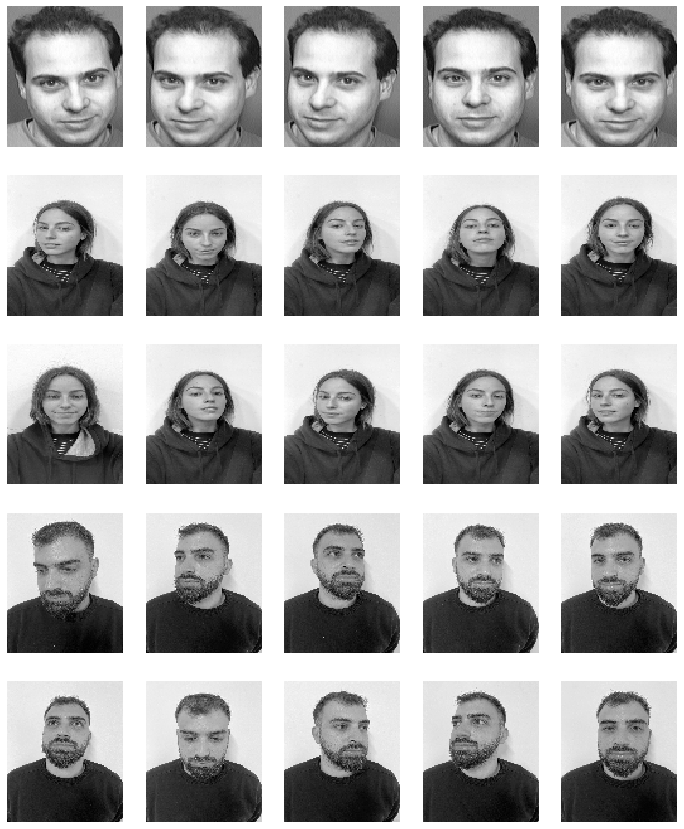

Face image size: (112, 92)
Number of classes: 42
Number of pictures: 420


In [191]:
###########################################################################
#                            START OF YOUR CODE                           #
###########################################################################
# add image(s) to data base
import zipfile
import cv2
import numpy as np

faces = {}
with zipfile.ZipFile("faces_dataset.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # If we extracted files from zip, we can use cv2.imread(filename)
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

picture_width = 92
picture_height = 112

for filename, image in faces.items():
    resized_image = cv2.resize(image, (picture_width, picture_height))
    faces[filename] = resized_image
    
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(12,15))
face_images = list(faces.values())[-25:]
for i in range(25):
    ax[i//5, i%5].imshow(face_images[i], cmap='gray')
    ax[i//5, i%5].axis('off')
plt.show()

faceshape = list(faces.values())[0].shape
print("Face image size:", faceshape)

classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of pictures:", len(faces))


facematrix = []
facelabel = []
for key,val in faces.items():
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])
 
# Create facematrix as (n_samples,n_pixels) matrix
facematrix = np.array(facematrix)

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

In [204]:
###########################################################################
#                            START OF YOUR CODE                           #
###########################################################################
# Re-calculate the PCA components
pca = PCA().fit(facematrix)
eigenfaces = pca.components_[:n_components]
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

### 3.2 quality vs #PCA elements
Show improvement in face image quality as a function of the number of PCA decomposition elements used to reconstruct the face image. Plot the MSE between the source image and the image in different phases of its reconstruction as more and more eigenfaces are added to the reconstructed image. Draw two graphs:
1. A linear graph showing the error - relative to the "zero" round error (when the initail phase reconstructed image is the average image of all faces) as a function of the number of iterations.
1. A logarithmic graph on the y-axis that does the same thing.

**Note:** there is already code that draws the two graphs. You only need to calculate the MSE function.

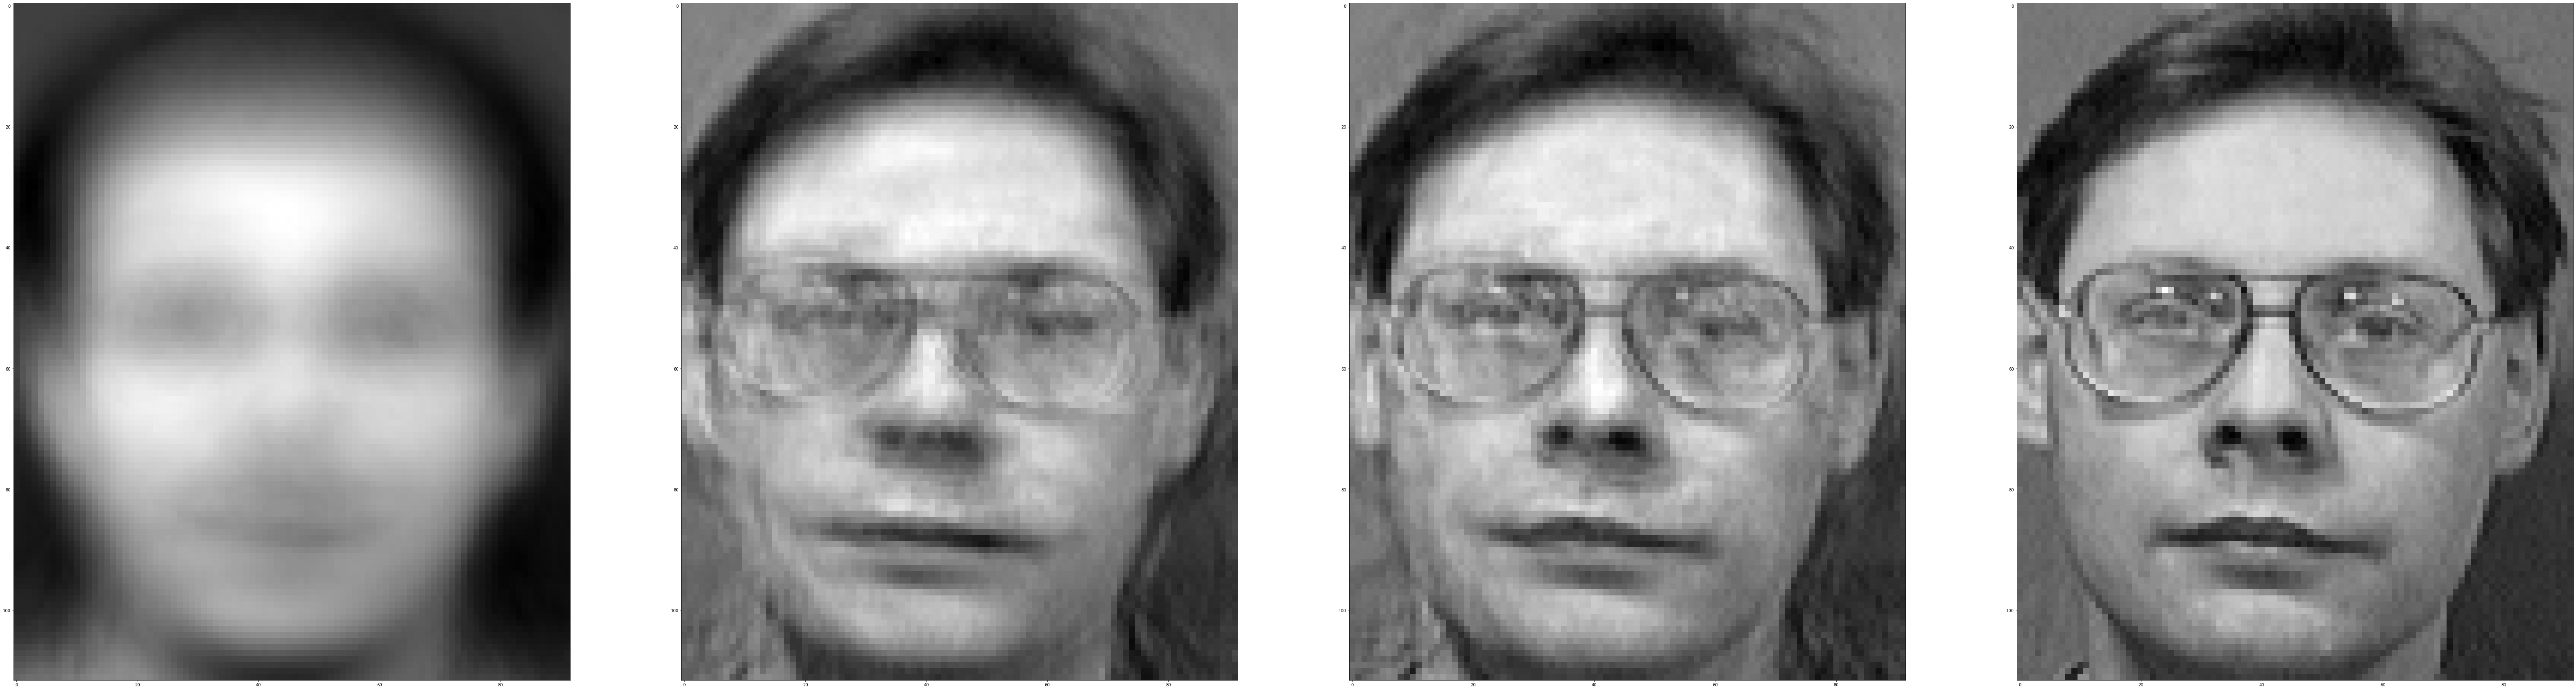

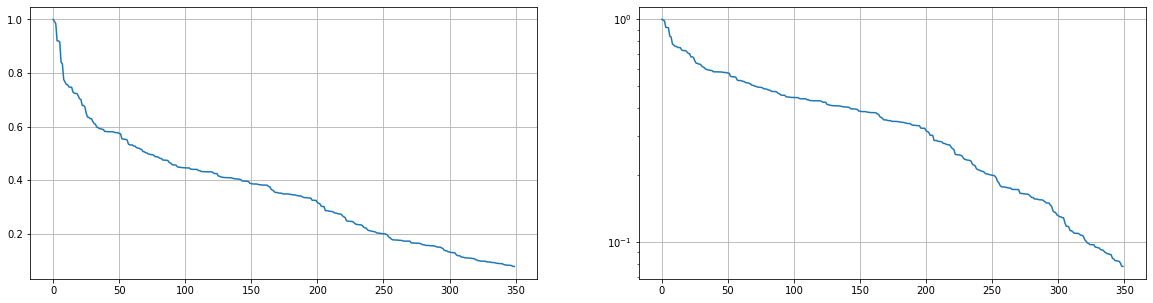

In [205]:
###########################################################################
#                            START OF YOUR CODE                           #
###########################################################################
# Test on out-of-sample image of existing class
query = faces["s4/1.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
mse = []
current_face = pca.mean_.copy()
for i in range(n_components):
    delta = eigenfaces[i]*query_weight[i] 
    current_face += delta
    error = dist(query, current_face)
    mse.append(error)

mse = np.array(mse)
# Show selected iterations with the eigenfaces
progresslist = [ 1, 100, 200, n_components-1]

fig, axes = plt.subplots(1, len(progresslist), figsize=(faceshape))

# Start constructing the target face by adding the eigenfaces with their respective weights
current_face = pca.mean_.copy()
j = 0

for i in range(n_components):
    delta =eigenfaces[i]*query_weight[i] 
    if i in progresslist:
        axes[j].imshow(current_face.reshape(faceshape), cmap="gray")
        j += 1

    current_face += delta

plt.show()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

axes[0].plot(mse/mse[0])
axes[0].grid()
axes[1].semilogy(mse/mse[0])
axes[1].grid()
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

### 3.3 morphing
Write a function that receives two images and displays a morphing process from the first image to the second by gradually changing the PCA weights of the first image, to the PCA weights of the second image. Do the process twice:

1. Morph between face "s7/1.pgm" and face "s7/4.pgm" in the database
1. Morph between two new face images you added at the begining of this question.

In [206]:
def morph(im1, im2):
    '''
    Receives two images and shows a graduae morphng from im1 to im2.
    :param im1: the source image.
    :param im2: the target image.
    
    Note: This funtion prints the iamges as it morph between them and return no value.
    '''
    ###########################################################################
    #                            START OF YOUR CODE                           #
    ###########################################################################
    no_of_iterations = 6

    fig, axes = plt.subplots(2, no_of_iterations, figsize=(faceshape))

    start_face = faces[im1].reshape(1,-1)   # Change this to be student no. 1 face image
    axes[0][0].imshow(start_face.reshape(faceshape), cmap="gray")

    end_face = faces[im2].reshape(1,-1)   # Change this to be student no. 2 face image
    axes[0][1].imshow(end_face.reshape(faceshape), cmap="gray")

    # Add here whatever is needed to initialise the morphing from start_image to end_image

    start_weights = eigenfaces @ (start_face - pca.mean_).T
    end_weights = eigenfaces @ (end_face - pca.mean_).T

    # Here you will calculate 'no_of_iterations' images that gradually shift from student1 image to student2
    for j in range(0,no_of_iterations):

        current_face = pca.mean_

        for i in range(n_components):
            # Write here whatever is needed to do the morphing between the two faces
            mid_weights = ((no_of_iterations - 1 - j) / (no_of_iterations - 1)) * start_weights + (j / (no_of_iterations - 1)) * end_weights
            delta = eigenfaces[i] * mid_weights[i]
            current_face = current_face + delta

        # This line displays the morphing for each j
        axes[1][j].imshow(current_face.reshape(faceshape), cmap="gray")


    plt.show()
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

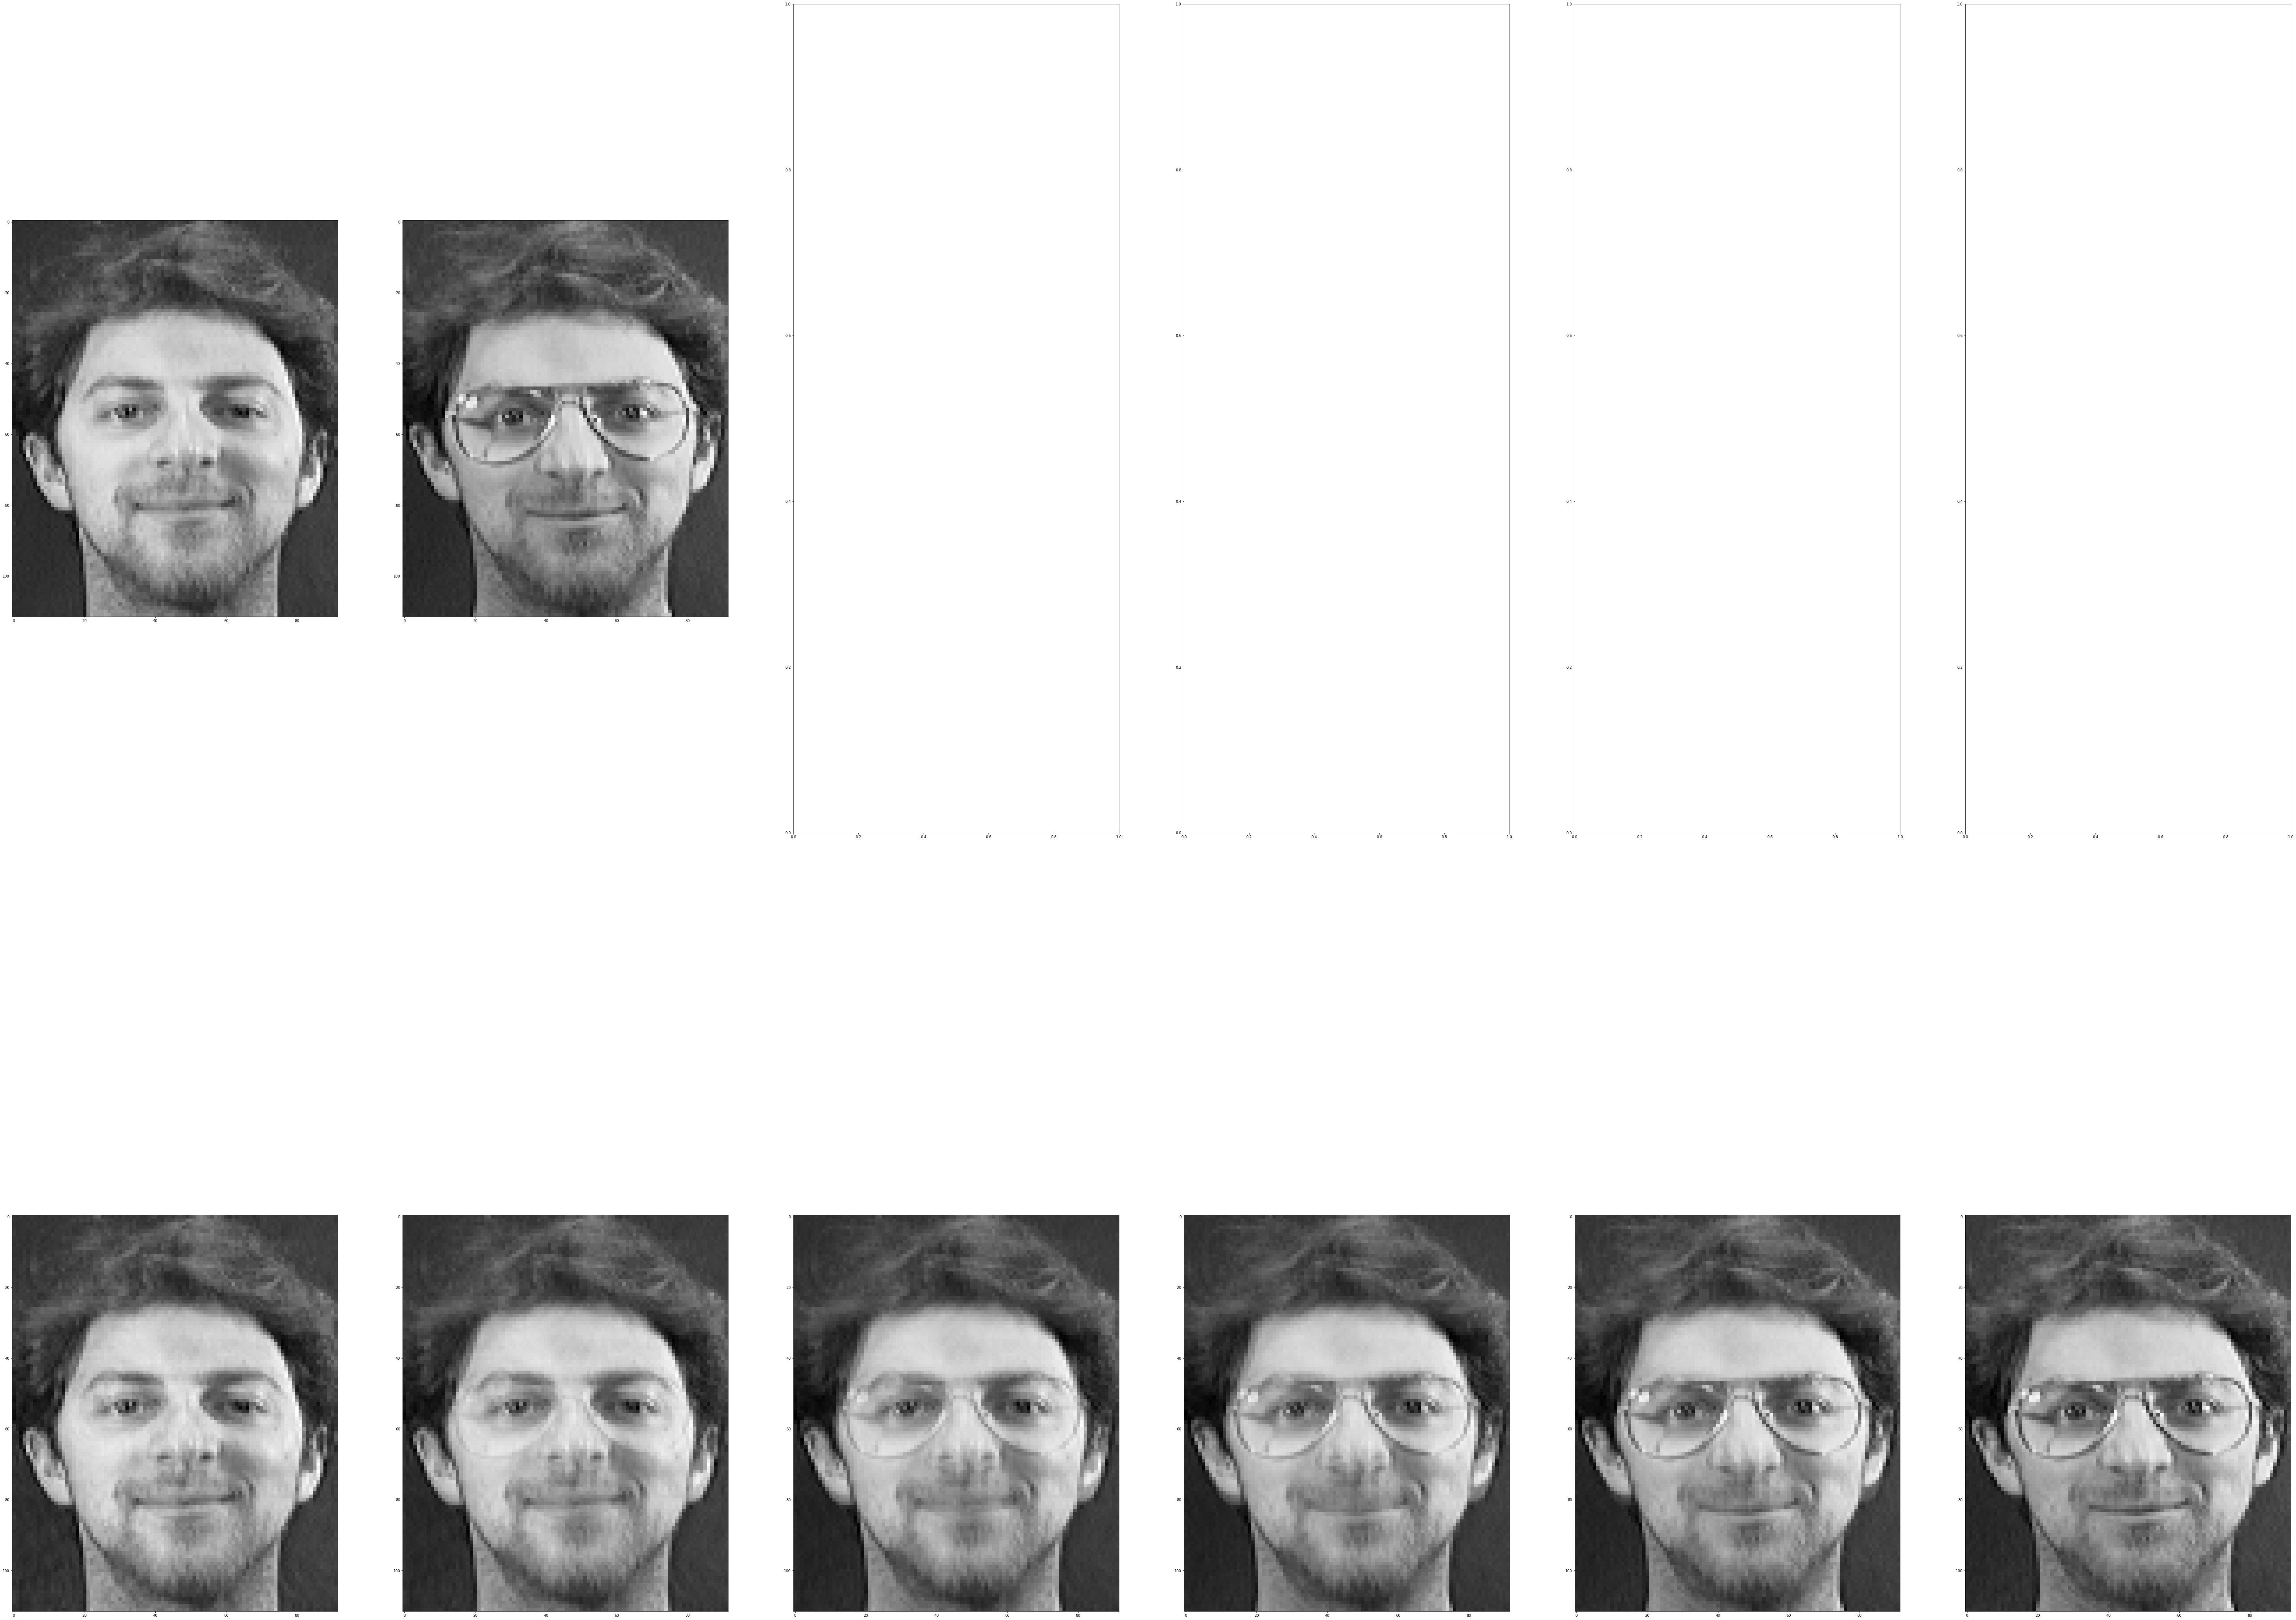

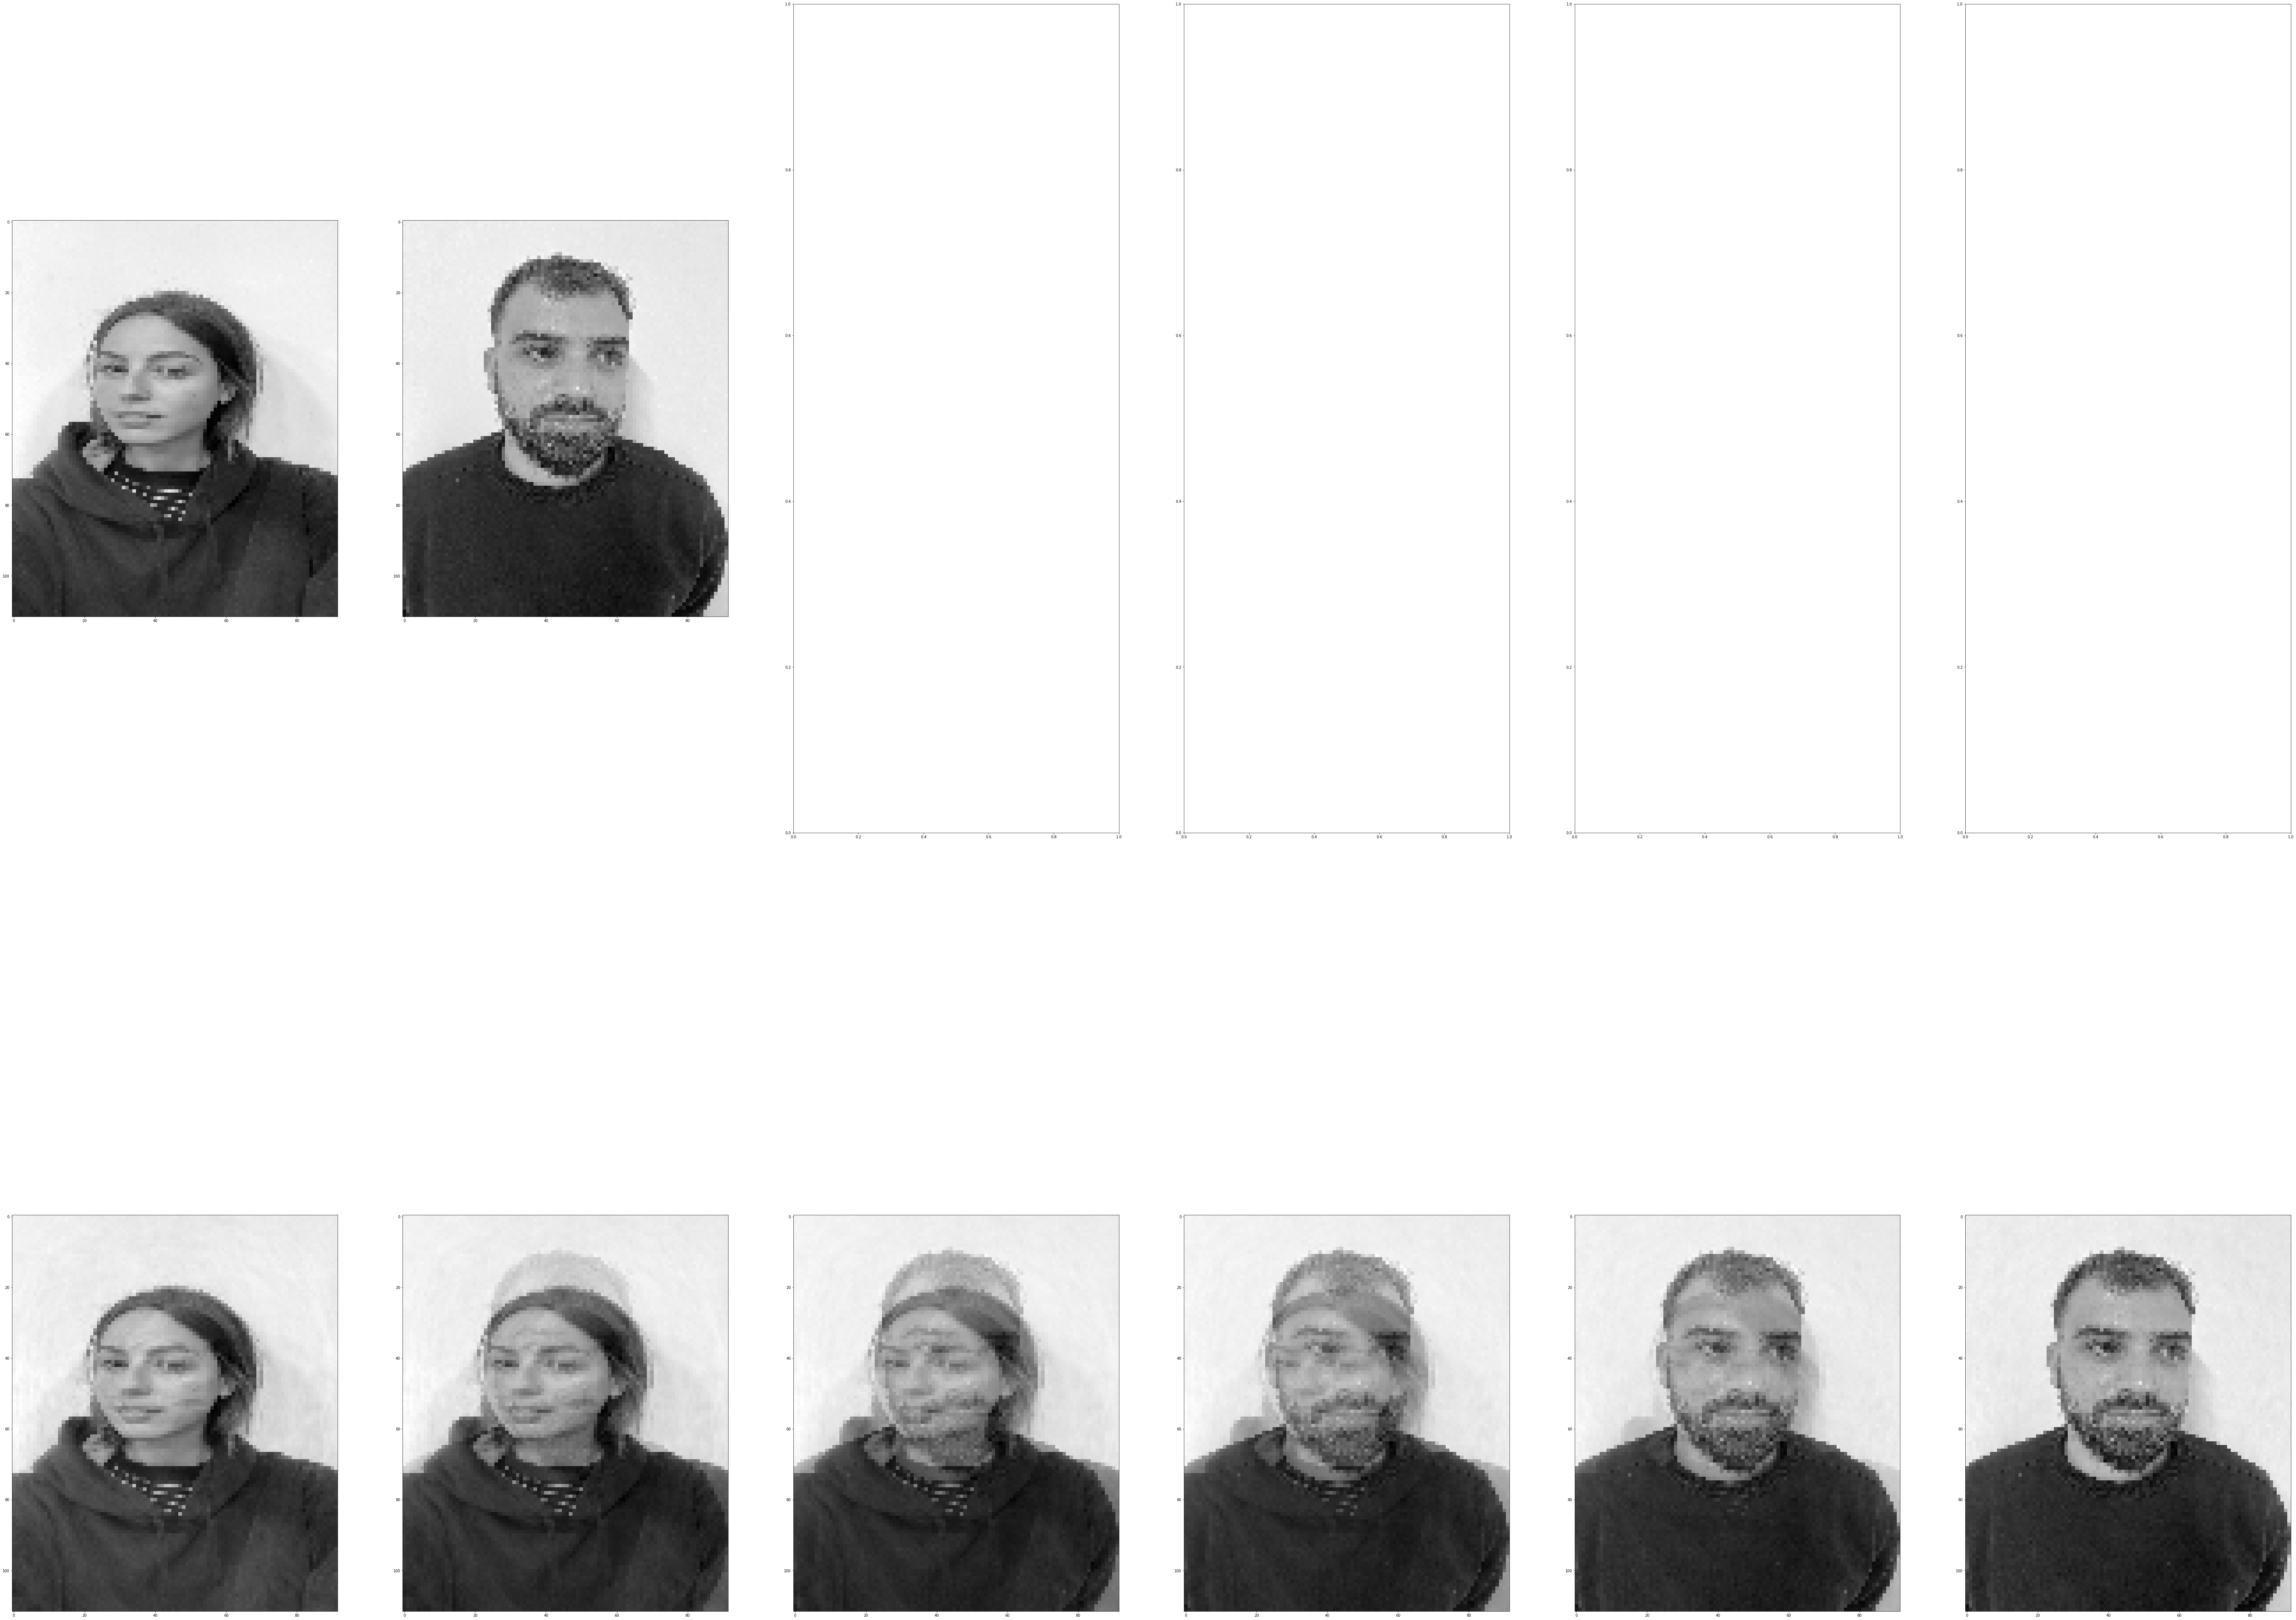

In [211]:
###########################################################################
#                            START OF YOUR CODE                           #
###########################################################################
morph('s7/1.pgm', 's7/4.pgm')
morph('s41/1.pgm', 's42/3.pgm')
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################